# This Notebook attempts to build a model with the categorical labels v2
 The testing and training were done on a 3 year and 4 year sliding window that are described below in appropriate cells

## The following rows were dropped when considering the model

*   the three rows at the end of 2019.rpt done by doing:

data = data.where(data.SegmentCode=="PH")

*   TaxStatus=1 (kept taxstatus 0 and 3)
* any row where *both* adjustedAmoutnDue1 and AdjustedTaxDue2 were 0
* removed all rows where LastPaymentSource2 was TPA (referred to payment data excel
* removed all rows where LastPaymentSource1 was TPA (referred to payment data excel
* removed all rows where diffpmt2 (difference in payment to duedate >=500)
* removed all rows where diffpmt1 (difference in payment to duedate >=500+180)

## The following rows were kept (interesting cases)

* LastPaymentSource1='000'


Final dataset length before test,train split:4280384


## Notes about OneHotEncoding Endeavor:
Initially tried to use StringIndexer,OnehotEnocoder to automate dummy variables
Further tried to use [this](https://www.skytowner.com/explore/one_hot_encoding_in_pyspark) website which at first glance did what I needed. I ran into issues with dealing with multiple categorical columns and how to combine the steps into one dataframe. Then I decided,  for the sake of time (ironically), I will manually create dummy variables. This turned out just fine for the conditions I described above.


In [1]:
# Mount to google drive where data is stored
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## PySpark Setup

In [2]:
# If you encounter any problems visit the apache.org link and ensure you have selected the right tgz file
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www.apache.org/dist/spark/spark-3.2.4/spark-3.2.4-bin-hadoop2.7.tgz
!tar xf spark-3.2.4-bin-hadoop2.7.tgz


In [ ]:
#import shutil

#shutil.rmtree('/content/gdrive/MyDrive/CSP 572/spark-3.2.4-bin-hadoop2.7')

In [3]:
# Setting the appropriate paths for Spark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.4-bin-hadoop2.7"

!pip install -q findspark
import findspark
findspark.init()

## Import libraries

In [4]:
import matplotlib.pyplot as plt

In [5]:

from pyspark.sql.functions import *
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit, to_timestamp, log
from pyspark.sql import Window
import pyspark.sql.functions as f
from pyspark.sql import Window
from pyspark.sql import functions as F
from pyspark.sql.types import StringType, DateType, FloatType
import pandas as pd
from pyspark.sql.functions import mean as _mean, stddev as _stddev, col

In [6]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
#!pip install pyspark_dist_explore
#from pyspark_dist_explore import hist
#import matplotlib.pyplot as plt

In [7]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, ConfusionMatrixDisplay

In [8]:
# Change directory
import os
os.chdir("/content/gdrive/MyDrive")

In [9]:

# Create a spark session
spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()


## Read Data

In [10]:
# Read 2021 data
data = spark.read.csv("2021.rpt", header=None, sep="|")

In [11]:
# Read the header file
header = pd.read_csv("Header.rpt", sep="|")
cols = header.columns
data = data.toDF(*cols)


In [12]:
# Read all other data files
#data_2022 = spark.read.csv("2022.rpt", header=None, sep="|")
data_2020 = spark.read.csv("2020.rpt", header=None, sep="|")
data_2019 = spark.read.csv("2019.rpt", header=None, sep="|")
data_2018 = spark.read.csv("2018.rpt", header=None, sep="|")
data_2017 = spark.read.csv("2017.rpt", header=None, sep="|")

In [13]:
# Combine all data
#data = data.union(data_2022)
data = data.union(data_2020)
data = data.union(data_2019)
data = data.union(data_2018)
data = data.union(data_2017)

In [14]:
for i in range(len(data.columns)):
  print(i,data.columns[i])

0 SegmentCode
1 PIN
2 Volume
3 Classification
4 TaxpayerName
5 TaxpayerMailingAddress
6 TaxpayerMailingCity
7 TaxpayerMailingState
8 TaxpayerMailingZip
9 TaxpayerPropertyHouse
10 TaxpayerPropertyDirection
11 TaxpayerPropertyStreet
12 TaxpayerPropertySuffix
13 TaxpayerPropertyCity
14 TaxpayerPropertyState
15 TaxpayerPropertyZip
16 TaxpayerPropertyTown
17 TaxCode
18 TaxStatus
19 HomeownerExempt
20 SeniorExempt
21 SeniorFreezeExempt
22 LongtimeHomeownersExempt
23 TaxInfoType
24 TaxType
25 TaxYear
26 BillYear
27 AccountStatus
28 BillType
29 SegmentCode2
30 InstallmentNumber1
31 AdjustedAmountDue1
32 TaxAmountDue1
33 RefundTaxAmountDueIndicator1
34 InterestAmountDue1
35 RefundInterestDueIndicator1
36 CostAmountDue1
37 RefundCostDueIndicator1
38 TotalAmountDue1
39 RefundTotalDueIndicator1
40 LastPaymentDate1
41 LastPaymentSource1
42 InstallmentNumber2
43 OriginalTaxDue2
44 AdjustedTaxDue2
45 TaxAmountDue2
46 RefundTaxAmountDueIndicator2
47 InterestAmountDue2
48 RefundInterestDueIndicator2
49

In [14]:
# Numeric columns list - add to this as you see fit
numeric_cols = ["AdjustedAmountDue1", "TaxAmountDue1", "InterestAmountDue1", "CostAmountDue1", "TotalAmountDue1", "OriginalTaxDue2",
        "AdjustedTaxDue2", "TaxAmountDue2", "InterestAmountDue2", "CostAmountDue2", "TotalAmountDue2", "AssessedValuation",
        "EqualizedEvaluation", "TaxRate", "LastPaymentReceivedAmount1", "LastPaymentReceivedAmount2"
        ] + list(data.columns)[70:81]

In [15]:
# Convert to numeric columns
for col_name in numeric_cols:
    data = data.withColumn(col_name, col(col_name).cast('float'))


# Remove 3 rows which have garbage values
data = data.where(data.SegmentCode=="PH")

In [16]:
data.count()

9325500

In [16]:
#data only should contain non-exempt accounts
data=data.where(data.TaxStatus!=1)

In [18]:
data.count()

8866794

In [17]:
data=data.filter((col('AdjustedAmountDue1') != 0) | (col('AdjustedTaxDue2') != 0))

In [21]:
data.count()

8634906

In [18]:
data=data.filter((col('LastPaymentSource2') != 527))
data=data.filter((col('LastPaymentSource2') != 600))
data=data.filter((col('LastPaymentSource2') != 800))
data=data.filter((col('LastPaymentSource2') != 802))
data=data.filter((col('LastPaymentSource2') != 830))

In [23]:
data.count()

4793935

In [19]:
data=data.filter((col('LastPaymentSource1') != 527))
data=data.filter((col('LastPaymentSource1') != 600))
data=data.filter((col('LastPaymentSource1') != 800))
data=data.filter((col('LastPaymentSource1') != 802))
data=data.filter((col('LastPaymentSource1') != 830))

In [20]:
data.count()

4597700

### Target Variable
Our target variable is Late Payment in 2nd Installment Y/N. We get this from the InstDates.csv (available in 'Helper datasets' folder in the shared drive) which contains the payment due dates of each year for each installment.

In [21]:
instDates = spark.read.csv("InstDates.csv", header=True)
instDates = instDates.withColumn("Year", col("Year").cast("int"))
instDates = instDates.where(instDates.Year>=2017)
instDates = instDates.withColumnRenamed("Inst1", "PmtDue1")
instDates = instDates.withColumnRenamed("Inst2", "PmtDue2")

In [24]:
instDates.show()

+----+----------+----------+
|Year|   PmtDue1|   PmtDue2|
+----+----------+----------+
|2017|2018-03-01|2018-08-01|
|2018|2019-03-01|2019-08-01|
|2019|2020-03-03|2020-08-03|
|2020|2021-03-02|2021-10-01|
|2021|2022-03-01|2023-01-03|
|2022|2023-04-03|      null|
+----+----------+----------+



In [25]:
#data=data.filter(data.LastPaymentDate2!='00000000')


In [21]:
data.filter(data.LastPaymentDate2=='00000000').show()


+-----------+--------------+------+--------------+--------------------+----------------------+--------------------+--------------------+------------------+---------------------+-------------------------+----------------------+----------------------+--------------------+---------------------+-------------------+--------------------+-------+---------+---------------+------------+------------------+------------------------+-----------+-------+-------+--------+-------------+--------+------------+------------------+------------------+-------------+----------------------------+------------------+---------------------------+--------------+-----------------------+---------------+------------------------+----------------+------------------+------------------+---------------+---------------+-------------+----------------------------+------------------+---------------------------+--------------+-----------------------+---------------+----------------------+----------------+------------------+----

In [22]:
data.filter(data.LastPaymentDate2=='00000000').count()

352328

In [26]:
temp=data.withColumn("LastPaymentDate2", to_date(col("LastPaymentDate2"), "MMddyyyy"))
temp.filter(temp.PIN=='08321010301031').show()

+-----------+--------------+------+--------------+--------------------+----------------------+--------------------+--------------------+------------------+---------------------+-------------------------+----------------------+----------------------+--------------------+---------------------+-------------------+--------------------+-------+---------+---------------+------------+------------------+------------------------+-----------+-------+-------+--------+-------------+--------+------------+------------------+------------------+-------------+----------------------------+------------------+---------------------------+--------------+-----------------------+---------------+------------------------+----------------+------------------+------------------+---------------+---------------+-------------+----------------------------+------------------+---------------------------+--------------+-----------------------+---------------+----------------------+----------------+------------------+----

In [31]:
data.filter((col('AdjustedTaxDue2') == 0)).count()

4773

In [22]:
data = data.join(instDates, data.TaxYear==instDates.Year, "left")
data = data.withColumn("LastPaymentDate1", to_date(col("LastPaymentDate1"), "MMddyyyy"))
data = data.withColumn("LastPaymentDate2", to_date(col("LastPaymentDate2"), "MMddyyyy"))
data = data.withColumn("PmtDue1", to_date(col("PmtDue1"), "yyyy-MM-dd"))
data = data.withColumn("PmtDue2", to_date(col("PmtDue2"), "yyyy-MM-dd"))
data = data.withColumn("LatePmt1", when(col("LastPaymentDate1")>col("PmtDue1"), 1).otherwise(0))
data = data.withColumn("LatePmt2", when(col("LastPaymentDate2")>col("PmtDue2"), 1).otherwise(0))


In [31]:
data.show(5)

+-----------+--------------+------+--------------+--------------------+----------------------+--------------------+--------------------+------------------+---------------------+-------------------------+----------------------+----------------------+--------------------+---------------------+-------------------+--------------------+-------+---------+---------------+------------+------------------+------------------------+-----------+-------+-------+--------+-------------+--------+------------+------------------+------------------+-------------+----------------------------+------------------+---------------------------+--------------+-----------------------+---------------+------------------------+----------------+------------------+------------------+---------------+---------------+-------------+----------------------------+------------------+---------------------------+--------------+-----------------------+---------------+----------------------+----------------+------------------+----

In [30]:
data.filter(data.LastPaymentDate2.isNull()).count() # count is still same for 00000000


352328

In [23]:
# replace null values with current date since no payments used to calculate diffpmt
data = data.withColumn('LastPaymentDate2', when(col('LastPaymentDate2').isNull(), current_date()).otherwise(col('LastPaymentDate2')))
data = data.withColumn('LastPaymentDate1', when(col('LastPaymentDate1').isNull(), current_date()).otherwise(col('LastPaymentDate1')))

In [33]:
data.filter(data.PIN=='08321010301031').show() #check known pin where paymentdate2 was initially 0 to make sure date format is correct

+-----------+--------------+------+--------------+--------------------+----------------------+--------------------+--------------------+------------------+---------------------+-------------------------+----------------------+----------------------+--------------------+---------------------+-------------------+--------------------+-------+---------+---------------+------------+------------------+------------------------+-----------+-------+-------+--------+-------------+--------+------------+------------------+------------------+-------------+----------------------------+------------------+---------------------------+--------------+-----------------------+---------------+------------------------+----------------+------------------+------------------+---------------+---------------+-------------+----------------------------+------------------+---------------------------+--------------+-----------------------+---------------+----------------------+----------------+------------------+----

In [ ]:
# Persist data in disk/memory
# Until this point Spark does not actually execute any of the above statements (Lazy loading). It only creates a plan
# Persist does not get executed until an 'action' command is called on the dataframe
#data1 = data.persist()

In [33]:
# The below action with persist called above will ensure that all the steps until data.persist() is run and stored in memory/disk
# Only the first run takes approx 10 mins. If you run it again, it will only take 3 secs as the data is now stored in memory/disk
# It helps in using the modified dataframe directly
# If you do not persist, Spark is going to run all the steps right from read_csv whenever you call an action
#print([data1.count(), len(data1.columns)])

In [24]:
data1 = data.persist()

In [25]:
data1.show(10)

+-----------+--------------+------+--------------+--------------------+----------------------+--------------------+--------------------+------------------+---------------------+-------------------------+----------------------+----------------------+--------------------+---------------------+-------------------+--------------------+-------+---------+---------------+------------+------------------+------------------------+-----------+-------+-------+--------+-------------+--------+------------+------------------+------------------+-------------+----------------------------+------------------+---------------------------+--------------+-----------------------+---------------+------------------------+----------------+------------------+------------------+---------------+---------------+-------------+----------------------------+------------------+---------------------------+--------------+-----------------------+---------------+----------------------+----------------+------------------+----

In [27]:
data1.count()

4597700

## Data Cleaning and Transformation

In [28]:
data1 = data1.withColumn("AdjustedAmountDue1", when(col("AdjustedAmountDue1")>3186751,3186751).otherwise(col("AdjustedAmountDue1")))

### Drop columns

- drop_cols_inst2 - Drop metrics related to installment2. This is needed for model 1 where we predict Late Payment for 2nd installment at Feb/Mar where we dont have this information yet
- drop_cols_univariate (Univariate analysis) - Group by categorical variables and get the count & %count of each category. If one of the categories in the feature is >95%, then remove this feature as it will not be very useful in the model. Some exceptions are present where the feature makes good business sense to be included
- drop_cols_numric_corr - Drop numerical columns that are correlated with Pearsons correlation >0.5


In [32]:
data1.columns

['SegmentCode',
 'PIN',
 'Volume',
 'Classification',
 'TaxpayerName',
 'TaxpayerMailingAddress',
 'TaxpayerMailingCity',
 'TaxpayerMailingState',
 'TaxpayerMailingZip',
 'TaxpayerPropertyHouse',
 'TaxpayerPropertyDirection',
 'TaxpayerPropertyStreet',
 'TaxpayerPropertySuffix',
 'TaxpayerPropertyCity',
 'TaxpayerPropertyState',
 'TaxpayerPropertyZip',
 'TaxpayerPropertyTown',
 'TaxCode',
 'TaxStatus',
 'HomeownerExempt',
 'SeniorExempt',
 'SeniorFreezeExempt',
 'LongtimeHomeownersExempt',
 'TaxInfoType',
 'TaxType',
 'TaxYear',
 'BillYear',
 'AccountStatus',
 'BillType',
 'SegmentCode2',
 'InstallmentNumber1',
 'AdjustedAmountDue1',
 'TaxAmountDue1',
 'RefundTaxAmountDueIndicator1',
 'InterestAmountDue1',
 'RefundInterestDueIndicator1',
 'CostAmountDue1',
 'RefundCostDueIndicator1',
 'TotalAmountDue1',
 'RefundTotalDueIndicator1',
 'LastPaymentDate1',
 'LastPaymentSource1',
 'InstallmentNumber2',
 'OriginalTaxDue2',
 'AdjustedTaxDue2',
 'TaxAmountDue2',
 'RefundTaxAmountDueIndicator2'

In [29]:
drop_cols_inst2 = data1.columns[42:53] + ["LastPaymentSource2"]
drop_cols_unrelated = ["SegmentCode", "TaxpayerName", "TaxpayerMailingAddress", "TaxpayerMailingZip",
                       "TaxpayerPropertyHouse","TaxpayerPropertyDirection", "TaxpayerPropertyStreet",
                       "TaxpayerPropertyZip", "RecordCount"
                       ]
drop_cols_univariate = ["LongtimeHomeownersExempt", "TaxInfoType", "TaxType", "TaxpayerPropertyState", "BillYear", "SegmentCode2",
                        "InstallmentNumber1", "RefundTaxAmountDueIndicator1", "RefundInterestDueIndicator1",
                        "RefundTotalDueIndicator1", "RefundCostDueIndicator1", "EndMarker", "TaxpayerMailingCity"
                        ]
drop_cols_numeric_corr = ["OriginalTaxDue2", "AdjustedTaxDue2", "AssessedValuation", "EqualizedEvaluation",
                          "LastPaymentReceivedAmount2", "TaxDueEstimated1", "LastPaymentReceivedAmount1",
                          "AdjustedAmountDue1_Org", "InterestAmountDue1", "TotalAmountDue1", "InterestAmountDue2",
                          "TotalAmountDue2", "SeniorExemptAmount", "VeteranExempt"]
drop_cols_unverfied = ["Volume", "Classification"] # dropped due to high cardinality but not verified by other reasons

In [30]:
data1 = data1.drop(*drop_cols_inst2)
data1 = data1.drop(*drop_cols_unrelated)
data1 = data1.drop(*drop_cols_univariate)
data1 = data1.drop(*drop_cols_numeric_corr)
data1 = data1.drop(*drop_cols_unverfied)

### Data Transformation

In [31]:
data1=data1.withColumn('TaxpayerMailingState', F.upper(F.col('TaxpayerMailingState')))

In [32]:
data2=data1.persist()

In [33]:
# Persist data in disk/memory
# Until this point Spark does not actually execute any of the above statements (Lazy loading). It only creates a plan
# Persist does not get executed until an 'action' command is called on the dataframe (action is count() here)

print([data2.count(), len(data2.columns)])

[4597700, 40]


In [38]:
data2.columns

['PIN',
 'TaxpayerMailingState',
 'TaxpayerPropertySuffix',
 'TaxpayerPropertyCity',
 'TaxpayerPropertyTown',
 'TaxCode',
 'TaxStatus',
 'HomeownerExempt',
 'SeniorExempt',
 'SeniorFreezeExempt',
 'TaxYear',
 'AccountStatus',
 'BillType',
 'AdjustedAmountDue1',
 'TaxAmountDue1',
 'CostAmountDue1',
 'LastPaymentDate1',
 'LastPaymentSource1',
 'LastPaymentDate2',
 'CofENumber',
 'PastTaxSaleStatus',
 'TaxRate',
 'CondemnationStatus',
 'MunicipalAcquisitionStatus',
 'AcquisitionStatus',
 'ExemptStatus',
 'BankruptStatus',
 'RefundStatus',
 'ReturningVetExemptionAmount',
 'DisabledPersonExemptionAmount',
 'DisabledVetExemptionAmount',
 'DisabledPersonVetExemptionAmount',
 'HomeownerExemptAmount',
 'SeniorFreezeExemptAmount',
 'LongtimeHomeownersExemptAmount',
 'Year',
 'PmtDue1',
 'PmtDue2',
 'LatePmt1',
 'LatePmt2']

In [60]:
data2.select(count_distinct('TaxCode')).show()

+-----------------------+
|count(DISTINCT TaxCode)|
+-----------------------+
|                   3143|
+-----------------------+



In [34]:
data2=data2.withColumn("AreaFromPin", substring(col("PIN"), 1, 2))

In [62]:
data2.select(count_distinct('AreaFromPin')).show()

+---------------------------+
|count(DISTINCT AreaFromPin)|
+---------------------------+
|                         33|
+---------------------------+



In [40]:
data2.select('AreaFromPin').distinct().collect()

[Row(AreaFromPin='07'),
 Row(AreaFromPin='11'),
 Row(AreaFromPin='01'),
 Row(AreaFromPin='09'),
 Row(AreaFromPin='08'),
 Row(AreaFromPin='03'),
 Row(AreaFromPin='02'),
 Row(AreaFromPin='10'),
 Row(AreaFromPin='12'),
 Row(AreaFromPin='13'),
 Row(AreaFromPin='05'),
 Row(AreaFromPin='06'),
 Row(AreaFromPin='04'),
 Row(AreaFromPin='14'),
 Row(AreaFromPin='15'),
 Row(AreaFromPin='22'),
 Row(AreaFromPin='16'),
 Row(AreaFromPin='18'),
 Row(AreaFromPin='17'),
 Row(AreaFromPin='19'),
 Row(AreaFromPin='23'),
 Row(AreaFromPin='24'),
 Row(AreaFromPin='20'),
 Row(AreaFromPin='21'),
 Row(AreaFromPin='29'),
 Row(AreaFromPin='28'),
 Row(AreaFromPin='27'),
 Row(AreaFromPin='26'),
 Row(AreaFromPin='25'),
 Row(AreaFromPin='30'),
 Row(AreaFromPin='31'),
 Row(AreaFromPin='33'),
 Row(AreaFromPin='32')]

In [41]:
data2.select('BillType').distinct().collect()

[Row(BillType='3'), Row(BillType='1'), Row(BillType='4')]

In [35]:
#data2 = data2.withColumn("TaxpayerPropertyCity", when(data2.TaxpayerPropertyCity=='CHICAGO               ', 1).otherwise(0))
data2 = data2.withColumn("TaxpayerMailingState", when(data2.TaxpayerMailingState=="IL", 1).otherwise(0))
#data2 = data2.withColumn("BillType", when(data2.BillType=="1", 1).otherwise(0))
#data2 = data2.withColumn("TaxSale", when(data2.LastPaymentDate2=="00000000", 1).otherwise(0))
data2 = data2.withColumn("CofENumber", when(data2.CofENumber=="0000000", 0).otherwise(1))
data2 = data2.withColumn("DiffPmt1", f.datediff(col("LastPaymentDate1"), col("PmtDue1")))
data2 = data2.withColumn("DiffPmt1", when(col("DiffPmt1")<0,0).otherwise(col("DiffPmt1")))
data2 = data2.withColumn("DiffPmt2", f.datediff(col("LastPaymentDate2"), col("PmtDue2")))
data2 = data2.withColumn("DiffPmt2", when(col("DiffPmt2")<0,0).otherwise(col("DiffPmt2")))
#data2 = data2.withColumn("Volume", col("Volume").cast("int"))
#data2 = data2.withColumn("TaxStatus", col("TaxStatus").cast("int"))
data2 = data2.withColumn("PastTaxSaleStatus", when(col("PastTaxSaleStatus")=="Y", 1).otherwise(0))

In [43]:
data2.dtypes

[('PIN', 'string'),
 ('TaxpayerMailingState', 'int'),
 ('TaxpayerPropertySuffix', 'string'),
 ('TaxpayerPropertyCity', 'string'),
 ('TaxpayerPropertyTown', 'string'),
 ('TaxCode', 'string'),
 ('TaxStatus', 'string'),
 ('HomeownerExempt', 'string'),
 ('SeniorExempt', 'string'),
 ('SeniorFreezeExempt', 'string'),
 ('TaxYear', 'string'),
 ('AccountStatus', 'string'),
 ('BillType', 'string'),
 ('AdjustedAmountDue1', 'float'),
 ('TaxAmountDue1', 'float'),
 ('CostAmountDue1', 'float'),
 ('LastPaymentDate1', 'date'),
 ('LastPaymentSource1', 'string'),
 ('LastPaymentDate2', 'date'),
 ('CofENumber', 'int'),
 ('PastTaxSaleStatus', 'int'),
 ('TaxRate', 'float'),
 ('CondemnationStatus', 'string'),
 ('MunicipalAcquisitionStatus', 'string'),
 ('AcquisitionStatus', 'string'),
 ('ExemptStatus', 'string'),
 ('BankruptStatus', 'string'),
 ('RefundStatus', 'string'),
 ('ReturningVetExemptionAmount', 'float'),
 ('DisabledPersonExemptionAmount', 'float'),
 ('DisabledVetExemptionAmount', 'float'),
 ('Disabl

In [46]:
data2.show() # I see PIN=08321010301031 had diffpm2>0 but marked as NOT LATE!!!
# I went back to check earlier cells and saw that I forgot to make those labels after fixing null dates but did it first instead and then changed null dates to current date

+--------------+--------------------+----------------------+--------------------+--------------------+-------+---------+---------------+------------+------------------+-------+-------------+--------+------------------+-------------+--------------+----------------+------------------+----------------+----------+-----------------+-------+------------------+--------------------------+-----------------+------------+--------------+------------+---------------------------+-----------------------------+--------------------------+--------------------------------+---------------------+------------------------+------------------------------+----+----------+----------+--------+--------+-----------+--------+--------+
|           PIN|TaxpayerMailingState|TaxpayerPropertySuffix|TaxpayerPropertyCity|TaxpayerPropertyTown|TaxCode|TaxStatus|HomeownerExempt|SeniorExempt|SeniorFreezeExempt|TaxYear|AccountStatus|BillType|AdjustedAmountDue1|TaxAmountDue1|CostAmountDue1|LastPaymentDate1|LastPaymentSource1|Las

In [36]:
# attempt fix to problem described in last cell here
data2 = data2.withColumn("LatePmt1", when(col("LastPaymentDate1")>col("PmtDue1"), 1).otherwise(0))
data2 = data2.withColumn("LatePmt2", when(col("LastPaymentDate2")>col("PmtDue2"), 1).otherwise(0))

In [37]:
# check data again!
data2.show()

+--------------+--------------------+----------------------+--------------------+--------------------+-------+---------+---------------+------------+------------------+-------+-------------+--------+------------------+-------------+--------------+----------------+------------------+----------------+----------+-----------------+-------+------------------+--------------------------+-----------------+------------+--------------+------------+---------------------------+-----------------------------+--------------------------+--------------------------------+---------------------+------------------------+------------------------------+----+----------+----------+--------+--------+-----------+--------+--------+
|           PIN|TaxpayerMailingState|TaxpayerPropertySuffix|TaxpayerPropertyCity|TaxpayerPropertyTown|TaxCode|TaxStatus|HomeownerExempt|SeniorExempt|SeniorFreezeExempt|TaxYear|AccountStatus|BillType|AdjustedAmountDue1|TaxAmountDue1|CostAmountDue1|LastPaymentDate1|LastPaymentSource1|Las

In [38]:
# drop rows where Diffpmt2 is >=500
data2 = data2.filter(col('DiffPmt2') < 500)
data2.count()

4306709

In [39]:
data2 = data2.filter(col('DiffPmt1') < 680)
data2.count()

4280384

In [ ]:
#further deciding to drop TaxpayerPropertyCity,TaxpayerPropertySuffix,TaxpayerPropertyTown, TaxCode.
# too much cardinality and 'AreafromPin' could  possibly be enough (havent done any real analysis)

### Drop other columns

In [40]:
other_cols = ["LastPaymentDate1", "LastPaymentDate2", "PmtDue1", "PmtDue2", "PIN", "Year"]

In [41]:
#data4 = data4.drop(*woe_transform_cols)
data2 = data2.drop(*other_cols)

In [47]:
# decided to insert again since the team has this as a variable
# data2 = data2.drop('LatePmt1')

In [42]:
data2=data2.drop('RefundStatus')#drop since univariate

In [43]:
data2=data2.drop('TaxCode')#drop for reasons explained earlier
data2=data2.drop('TaxpayerPropertySuffix')
data2=data2.drop('TaxpayerPropertyTown')
data2=data2.drop('TaxpayerPropertyCity')

In [44]:
# drop diffpmt2
data2=data2.drop('DiffPmt2')

In [45]:
data2.dtypes

[('TaxpayerMailingState', 'int'),
 ('TaxStatus', 'string'),
 ('HomeownerExempt', 'string'),
 ('SeniorExempt', 'string'),
 ('SeniorFreezeExempt', 'string'),
 ('TaxYear', 'string'),
 ('AccountStatus', 'string'),
 ('BillType', 'string'),
 ('AdjustedAmountDue1', 'float'),
 ('TaxAmountDue1', 'float'),
 ('CostAmountDue1', 'float'),
 ('LastPaymentSource1', 'string'),
 ('CofENumber', 'int'),
 ('PastTaxSaleStatus', 'int'),
 ('TaxRate', 'float'),
 ('CondemnationStatus', 'string'),
 ('MunicipalAcquisitionStatus', 'string'),
 ('AcquisitionStatus', 'string'),
 ('ExemptStatus', 'string'),
 ('BankruptStatus', 'string'),
 ('ReturningVetExemptionAmount', 'float'),
 ('DisabledPersonExemptionAmount', 'float'),
 ('DisabledVetExemptionAmount', 'float'),
 ('DisabledPersonVetExemptionAmount', 'float'),
 ('HomeownerExemptAmount', 'float'),
 ('SeniorFreezeExemptAmount', 'float'),
 ('LongtimeHomeownersExemptAmount', 'float'),
 ('LatePmt1', 'int'),
 ('LatePmt2', 'int'),
 ('AreaFromPin', 'string'),
 ('DiffPmt1', 

## Model Building

In [ ]:
#feature_cols = data4.columns
#feature_cols.remove("LatePmt2")

In [46]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

# Convert all features into a vector with name 'features'
#assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
#data4 = assembler.transform(data4)

In [47]:
categorical_feats=['TaxpayerMailingState','TaxStatus',
                                   'HomeownerExempt','SeniorExempt', 'SeniorFreezeExempt',
                                    'AccountStatus', 'BillType','LastPaymentSource1','CofENumber',
                                    'PastTaxSaleStatus', 'CondemnationStatus',
                                   'MunicipalAcquisitionStatus', 'AcquisitionStatus','ExemptStatus','BankruptStatus',
                                    'AreaFromPin','LatePmt1']

In [63]:
for x in categorical_feats:
  print(data2.select(x).distinct().collect())


[Row(TaxpayerMailingState=1), Row(TaxpayerMailingState=0)]
[Row(TaxStatus='00'), Row(TaxStatus='05'), Row(TaxStatus='03')]
[Row(HomeownerExempt='0'), Row(HomeownerExempt='1'), Row(HomeownerExempt='2')]
[Row(SeniorExempt='0'), Row(SeniorExempt='1'), Row(SeniorExempt='2')]
[Row(SeniorFreezeExempt='0'), Row(SeniorFreezeExempt='1'), Row(SeniorFreezeExempt='2')]
[Row(AccountStatus='O'), Row(AccountStatus='P')]
[Row(BillType='3'), Row(BillType='1'), Row(BillType='4')]
[Row(LastPaymentSource1='700'), Row(LastPaymentSource1='521'), Row(LastPaymentSource1='428'), Row(LastPaymentSource1='422'), Row(LastPaymentSource1='432'), Row(LastPaymentSource1='423'), Row(LastPaymentSource1='421'), Row(LastPaymentSource1='505'), Row(LastPaymentSource1='801'), Row(LastPaymentSource1='501'), Row(LastPaymentSource1='525'), Row(LastPaymentSource1='436'), Row(LastPaymentSource1='437'), Row(LastPaymentSource1='526'), Row(LastPaymentSource1='427'), Row(LastPaymentSource1='444'), Row(LastPaymentSource1='750'), Row(L

### very, extremely inefficient way of one-hot encoding

In [48]:
data2 = data2.withColumn("TaxpayerMailingState_IL", when(data2.TaxpayerMailingState == 1, 1).otherwise(0))
data2 = data2.withColumn('TaxpayerMailingState_nonIL', when(col('TaxpayerMailingState') == 0, 1).otherwise(0))

data2 = data2.withColumn('TaxStatus_00', when(col('TaxStatus') == '00', 1).otherwise(0))
data2 = data2.withColumn('TaxStatus_05', when(col('TaxStatus') == '05', 1).otherwise(0))
data2 = data2.withColumn('TaxStatus_03', when(col('TaxStatus') == '03', 1).otherwise(0))

data2 = data2.withColumn('HomeownerExempt_0', when(col('HomeownerExempt') == '0', 1).otherwise(0))
data2 = data2.withColumn('HomeownerExempt_1', when(col('HomeownerExempt') == '1', 1).otherwise(0))
data2 = data2.withColumn('HomeownerExempt_2', when(col('HomeownerExempt') == '2', 1).otherwise(0))

data2 = data2.withColumn('SeniorExempt_0', when(col('SeniorExempt') == '0', 1).otherwise(0))
data2 = data2.withColumn('SeniorExempt_1', when(col('SeniorExempt') == '1', 1).otherwise(0))
data2 = data2.withColumn('SeniorExempt_2', when(col('SeniorExempt') == '2', 1).otherwise(0))

data2 = data2.withColumn('SeniorFreezeExempt_0', when(col('SeniorFreezeExempt') == '0', 1).otherwise(0))
data2 = data2.withColumn('SeniorFreezeExempt_1', when(col('SeniorFreezeExempt') == '1', 1).otherwise(0))
data2 = data2.withColumn('SeniorFreezeExempt_2', when(col('SeniorFreezeExempt') == '2', 1).otherwise(0))

data2 = data2.withColumn('AccountStatus_O', when(col('AccountStatus') == 'O', 1).otherwise(0))
data2 = data2.withColumn('AccountStatus_P', when(col('AccountStatus') == 'P', 1).otherwise(0))

data2 = data2.withColumn('BillType_3', when(col('BillType') == '3', 1).otherwise(0))
data2 = data2.withColumn('BillType_1', when(col('BillType') == '1', 1).otherwise(0))
data2 = data2.withColumn('BillType_4', when(col('BillType') == '4', 1).otherwise(0))


In [49]:
data2 = data2.withColumn('LastPaymentSource1_700', when(col('LastPaymentSource1') == '700', 1).otherwise(0))
data2 = data2.withColumn('LastPaymentSource1_521', when(col('LastPaymentSource1') == '521', 1).otherwise(0))
data2 = data2.withColumn('LastPaymentSource1_428', when(col('LastPaymentSource1') == '428', 1).otherwise(0))
data2 = data2.withColumn('LastPaymentSource1_422', when(col('LastPaymentSource1') == '422', 1).otherwise(0))
data2 = data2.withColumn('LastPaymentSource1_432', when(col('LastPaymentSource1') == '432', 1).otherwise(0))
data2 = data2.withColumn('LastPaymentSource1_423', when(col('LastPaymentSource1') == '423', 1).otherwise(0))
data2 = data2.withColumn('LastPaymentSource1_421', when(col('LastPaymentSource1') == '421', 1).otherwise(0))
data2 = data2.withColumn('LastPaymentSource1_505', when(col('LastPaymentSource1') == '505', 1).otherwise(0))
data2 = data2.withColumn('LastPaymentSource1_801', when(col('LastPaymentSource1') == '801', 1).otherwise(0))
data2 = data2.withColumn('LastPaymentSource1_501', when(col('LastPaymentSource1') == '501', 1).otherwise(0))
data2 = data2.withColumn('LastPaymentSource1_525', when(col('LastPaymentSource1') == '525', 1).otherwise(0))
data2 = data2.withColumn('LastPaymentSource1_436', when(col('LastPaymentSource1') == '436', 1).otherwise(0))
data2 = data2.withColumn('LastPaymentSource1_437', when(col('LastPaymentSource1') == '437', 1).otherwise(0))
data2 = data2.withColumn('LastPaymentSource1_526', when(col('LastPaymentSource1') == '526', 1).otherwise(0))
data2 = data2.withColumn('LastPaymentSource1_427', when(col('LastPaymentSource1') == '427', 1).otherwise(0))
data2 = data2.withColumn('LastPaymentSource1_444', when(col('LastPaymentSource1') == '444', 1).otherwise(0))
data2 = data2.withColumn('LastPaymentSource1_750', when(col('LastPaymentSource1') == '750', 1).otherwise(0))
data2 = data2.withColumn('LastPaymentSource1_463', when(col('LastPaymentSource1') == '463', 1).otherwise(0))
data2 = data2.withColumn('LastPaymentSource1_431', when(col('LastPaymentSource1') == '431', 1).otherwise(0))
data2 = data2.withColumn('LastPaymentSource1_426', when(col('LastPaymentSource1') == '426', 1).otherwise(0))
data2 = data2.withColumn('LastPaymentSource1_000', when(col('LastPaymentSource1') == '000', 1).otherwise(0))
data2 = data2.withColumn('LastPaymentSource1_831', when(col('LastPaymentSource1') == '831', 1).otherwise(0))
data2 = data2.withColumn('LastPaymentSource1_476', when(col('LastPaymentSource1') == '476', 1).otherwise(0))
data2 = data2.withColumn('LastPaymentSource1_407', when(col('LastPaymentSource1') == '407', 1).otherwise(0))
data2 = data2.withColumn('LastPaymentSource1_823', when(col('LastPaymentSource1') == '823', 1).otherwise(0))
data2 = data2.withColumn('LastPaymentSource1_481', when(col('LastPaymentSource1') == '481', 1).otherwise(0))
data2 = data2.withColumn('LastPaymentSource1_477', when(col('LastPaymentSource1') == '477', 1).otherwise(0))
data2 = data2.withColumn('LastPaymentSource1_486', when(col('LastPaymentSource1') == '486', 1).otherwise(0))
data2 = data2.withColumn('LastPaymentSource1_471', when(col('LastPaymentSource1') == '471', 1).otherwise(0))
data2 = data2.withColumn('LastPaymentSource1_482', when(col('LastPaymentSource1') == '482', 1).otherwise(0))
data2 = data2.withColumn('LastPaymentSource1_472', when(col('LastPaymentSource1') == '472', 1).otherwise(0))
data2 = data2.withColumn('LastPaymentSource1_487', when(col('LastPaymentSource1') == '487', 1).otherwise(0))
data2 = data2.withColumn('LastPaymentSource1_478', when(col('LastPaymentSource1') == '478', 1).otherwise(0))
data2 = data2.withColumn('LastPaymentSource1_473', when(col('LastPaymentSource1') == '473', 1).otherwise(0))
data2 = data2.withColumn('LastPaymentSource1_522', when(col('LastPaymentSource1') == '522', 1).otherwise(0))


In [50]:
data2 = data2.withColumn('CofENumber_0', when(col('CofENumber') == 0, 1).otherwise(0))
data2 = data2.withColumn('CofENumber_non0', when(col('CofENumber') == 1, 1).otherwise(0))

data2 = data2.withColumn('PastTaxSaleStatus_Y', when(col('PastTaxSaleStatus') == 1, 1).otherwise(0))
data2 = data2.withColumn('PastTaxSaleStatus_N', when(col('PastTaxSaleStatus') == 0, 1).otherwise(0))

data2 = data2.withColumn('CondemnationStatus_0', when(col('CondemnationStatus') == '0', 1).otherwise(0))
data2 = data2.withColumn('CondemnationStatus_1', when(col('CondemnationStatus') == '1', 1).otherwise(0))

data2 = data2.withColumn('MunicipalAcquisitionStatus_0', when(col('MunicipalAcquisitionStatus') == '0', 1).otherwise(0))
data2 = data2.withColumn('MunicipalAcquisitionStatus_1', when(col('MunicipalAcquisitionStatus') == '1', 1).otherwise(0))

data2 = data2.withColumn('MunicipalAcquisitionStatus_1', when(col('MunicipalAcquisitionStatus') == '1', 1).otherwise(0))
data2 = data2.withColumn('MunicipalAcquisitionStatus_1', when(col('MunicipalAcquisitionStatus') == '1', 1).otherwise(0))

data2 = data2.withColumn('ExemptStatus_0', when(col('ExemptStatus') == '0', 1).otherwise(0))
data2 = data2.withColumn('ExemptStatus_1', when(col('ExemptStatus') == '1', 1).otherwise(0))
data2 = data2.withColumn('ExemptStatus_2', when(col('ExemptStatus') == '2', 1).otherwise(0))

data2 = data2.withColumn('BankruptStatus_0', when(col('BankruptStatus') == '0', 1).otherwise(0))
data2 = data2.withColumn('BankruptStatus_1', when(col('BankruptStatus') == '1', 1).otherwise(0))



In [51]:
data2 = data2.withColumn('AreaFromPin_01', when(col('AreaFromPin') == '01', 1).otherwise(0))
data2 = data2.withColumn('AreaFromPin_02', when(col('AreaFromPin') == '02', 1).otherwise(0))
data2 = data2.withColumn('AreaFromPin_03', when(col('AreaFromPin') == '03', 1).otherwise(0))
data2 = data2.withColumn('AreaFromPin_04', when(col('AreaFromPin') == '04', 1).otherwise(0))
data2 = data2.withColumn('AreaFromPin_05', when(col('AreaFromPin') == '05', 1).otherwise(0))
data2 = data2.withColumn('AreaFromPin_06', when(col('AreaFromPin') == '06', 1).otherwise(0))
data2 = data2.withColumn('AreaFromPin_07', when(col('AreaFromPin') == '07', 1).otherwise(0))
data2 = data2.withColumn('AreaFromPin_08', when(col('AreaFromPin') == '08', 1).otherwise(0))
data2 = data2.withColumn('AreaFromPin_09', when(col('AreaFromPin') == '09', 1).otherwise(0))
data2 = data2.withColumn('AreaFromPin_10', when(col('AreaFromPin') == '10', 1).otherwise(0))
data2 = data2.withColumn('AreaFromPin_11', when(col('AreaFromPin') == '11', 1).otherwise(0))
data2 = data2.withColumn('AreaFromPin_12', when(col('AreaFromPin') == '12', 1).otherwise(0))
data2 = data2.withColumn('AreaFromPin_13', when(col('AreaFromPin') == '13', 1).otherwise(0))
data2 = data2.withColumn('AreaFromPin_14', when(col('AreaFromPin') == '14', 1).otherwise(0))
data2 = data2.withColumn('AreaFromPin_15', when(col('AreaFromPin') == '15', 1).otherwise(0))
data2 = data2.withColumn('AreaFromPin_16', when(col('AreaFromPin') == '16', 1).otherwise(0))
data2 = data2.withColumn('AreaFromPin_17', when(col('AreaFromPin') == '17', 1).otherwise(0))
data2 = data2.withColumn('AreaFromPin_18', when(col('AreaFromPin') == '18', 1).otherwise(0))
data2 = data2.withColumn('AreaFromPin_19', when(col('AreaFromPin') == '19', 1).otherwise(0))
data2 = data2.withColumn('AreaFromPin_20', when(col('AreaFromPin') == '20', 1).otherwise(0))
data2 = data2.withColumn('AreaFromPin_21', when(col('AreaFromPin') == '21', 1).otherwise(0))
data2 = data2.withColumn('AreaFromPin_22', when(col('AreaFromPin') == '22', 1).otherwise(0))
data2 = data2.withColumn('AreaFromPin_23', when(col('AreaFromPin') == '23', 1).otherwise(0))
data2 = data2.withColumn('AreaFromPin_24', when(col('AreaFromPin') == '24', 1).otherwise(0))
data2 = data2.withColumn('AreaFromPin_25', when(col('AreaFromPin') == '25', 1).otherwise(0))
data2 = data2.withColumn('AreaFromPin_26', when(col('AreaFromPin') == '26', 1).otherwise(0))
data2 = data2.withColumn('AreaFromPin_27', when(col('AreaFromPin') == '27', 1).otherwise(0))
data2 = data2.withColumn('AreaFromPin_28', when(col('AreaFromPin') == '28', 1).otherwise(0))
data2 = data2.withColumn('AreaFromPin_29', when(col('AreaFromPin') == '29', 1).otherwise(0))
data2 = data2.withColumn('AreaFromPin_30', when(col('AreaFromPin') == '30', 1).otherwise(0))
data2 = data2.withColumn('AreaFromPin_31', when(col('AreaFromPin') == '31', 1).otherwise(0))
data2 = data2.withColumn('AreaFromPin_32', when(col('AreaFromPin') == '32', 1).otherwise(0))
data2 = data2.withColumn('AreaFromPin_33', when(col('AreaFromPin') == '33', 1).otherwise(0))


In [52]:
data2 = data2.withColumn('LatePmt1_1', when(col('LatePmt1') == 1, 1).otherwise(0))
data2 = data2.withColumn('LatePmt1_0', when(col('LatePmt1') == 0, 1).otherwise(0))

In [74]:
data2.show()

+--------------------+---------+---------------+------------+------------------+-------+-------------+--------+------------------+-------------+--------------+------------------+----------+-----------------+-------+------------------+--------------------------+-----------------+------------+--------------+---------------------------+-----------------------------+--------------------------+--------------------------------+---------------------+------------------------+------------------------------+--------+--------+-----------+--------+-----------------------+--------------------------+------------+------------+------------+-----------------+-----------------+-----------------+--------------+--------------+--------------+--------------------+--------------------+--------------------+---------------+---------------+----------+----------+----------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+---

In [75]:
data2.columns # still includes original non-ohe categorical columns

['TaxpayerMailingState',
 'TaxStatus',
 'HomeownerExempt',
 'SeniorExempt',
 'SeniorFreezeExempt',
 'TaxYear',
 'AccountStatus',
 'BillType',
 'AdjustedAmountDue1',
 'TaxAmountDue1',
 'CostAmountDue1',
 'LastPaymentSource1',
 'CofENumber',
 'PastTaxSaleStatus',
 'TaxRate',
 'CondemnationStatus',
 'MunicipalAcquisitionStatus',
 'AcquisitionStatus',
 'ExemptStatus',
 'BankruptStatus',
 'ReturningVetExemptionAmount',
 'DisabledPersonExemptionAmount',
 'DisabledVetExemptionAmount',
 'DisabledPersonVetExemptionAmount',
 'HomeownerExemptAmount',
 'SeniorFreezeExemptAmount',
 'LongtimeHomeownersExemptAmount',
 'LatePmt1',
 'LatePmt2',
 'AreaFromPin',
 'DiffPmt1',
 'TaxpayerMailingState_IL',
 'TaxpayerMailingState_nonIL',
 'TaxStatus_00',
 'TaxStatus_05',
 'TaxStatus_03',
 'HomeownerExempt_0',
 'HomeownerExempt_1',
 'HomeownerExempt_2',
 'SeniorExempt_0',
 'SeniorExempt_1',
 'SeniorExempt_2',
 'SeniorFreezeExempt_0',
 'SeniorFreezeExempt_1',
 'SeniorFreezeExempt_2',
 'AccountStatus_O',
 'Accou

In [53]:
# remove original non-ohe categorical columns but left with label column and tax year
features_list = [x for x in data2.columns if x not in categorical_feats]
features_list

['TaxYear',
 'AdjustedAmountDue1',
 'TaxAmountDue1',
 'CostAmountDue1',
 'TaxRate',
 'ReturningVetExemptionAmount',
 'DisabledPersonExemptionAmount',
 'DisabledVetExemptionAmount',
 'DisabledPersonVetExemptionAmount',
 'HomeownerExemptAmount',
 'SeniorFreezeExemptAmount',
 'LongtimeHomeownersExemptAmount',
 'LatePmt2',
 'DiffPmt1',
 'TaxpayerMailingState_IL',
 'TaxpayerMailingState_nonIL',
 'TaxStatus_00',
 'TaxStatus_05',
 'TaxStatus_03',
 'HomeownerExempt_0',
 'HomeownerExempt_1',
 'HomeownerExempt_2',
 'SeniorExempt_0',
 'SeniorExempt_1',
 'SeniorExempt_2',
 'SeniorFreezeExempt_0',
 'SeniorFreezeExempt_1',
 'SeniorFreezeExempt_2',
 'AccountStatus_O',
 'AccountStatus_P',
 'BillType_3',
 'BillType_1',
 'BillType_4',
 'LastPaymentSource1_700',
 'LastPaymentSource1_521',
 'LastPaymentSource1_428',
 'LastPaymentSource1_422',
 'LastPaymentSource1_432',
 'LastPaymentSource1_423',
 'LastPaymentSource1_421',
 'LastPaymentSource1_505',
 'LastPaymentSource1_801',
 'LastPaymentSource1_501',
 'L

In [54]:
# feature list has all features to be used in model
features_list = [x for x in features_list if x not in ['TaxYear','LatePmt2']]
features_list

['AdjustedAmountDue1',
 'TaxAmountDue1',
 'CostAmountDue1',
 'TaxRate',
 'ReturningVetExemptionAmount',
 'DisabledPersonExemptionAmount',
 'DisabledVetExemptionAmount',
 'DisabledPersonVetExemptionAmount',
 'HomeownerExemptAmount',
 'SeniorFreezeExemptAmount',
 'LongtimeHomeownersExemptAmount',
 'DiffPmt1',
 'TaxpayerMailingState_IL',
 'TaxpayerMailingState_nonIL',
 'TaxStatus_00',
 'TaxStatus_05',
 'TaxStatus_03',
 'HomeownerExempt_0',
 'HomeownerExempt_1',
 'HomeownerExempt_2',
 'SeniorExempt_0',
 'SeniorExempt_1',
 'SeniorExempt_2',
 'SeniorFreezeExempt_0',
 'SeniorFreezeExempt_1',
 'SeniorFreezeExempt_2',
 'AccountStatus_O',
 'AccountStatus_P',
 'BillType_3',
 'BillType_1',
 'BillType_4',
 'LastPaymentSource1_700',
 'LastPaymentSource1_521',
 'LastPaymentSource1_428',
 'LastPaymentSource1_422',
 'LastPaymentSource1_432',
 'LastPaymentSource1_423',
 'LastPaymentSource1_421',
 'LastPaymentSource1_505',
 'LastPaymentSource1_801',
 'LastPaymentSource1_501',
 'LastPaymentSource1_525',
 

In [55]:
# create vector of features
vec_assembler = VectorAssembler(inputCols=features_list,outputCol='features')
vec_df = vec_assembler.transform(data2)


In [79]:
vec_df.show(5,truncate=False)

+--------------------+---------+---------------+------------+------------------+-------+-------------+--------+------------------+-------------+--------------+------------------+----------+-----------------+-------+------------------+--------------------------+-----------------+------------+--------------+---------------------------+-----------------------------+--------------------------+--------------------------------+---------------------+------------------------+------------------------------+--------+--------+-----------+--------+-----------------------+--------------------------+------------+------------+------------+-----------------+-----------------+-----------------+--------------+--------------+--------------+--------------------+--------------------+--------------------+---------------+---------------+----------+----------+----------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+---

In [78]:
#train test split based on years
test2021=vec_df.filter(col('TaxYear')==2021)
train3year=vec_df.filter((col('TaxYear')==2018) |(col('TaxYear')==2019)|(col('TaxYear')==2020)) # only include 3 years before test set
train4year=vec_df.filter(col('TaxYear')!=2021) # keep everything except 2021

In [ ]:
# Test train split
# train, test = vec_df.randomSplit([0.8,0.2], seed=100)

In [57]:
train4year.columns

['TaxpayerMailingState',
 'TaxStatus',
 'HomeownerExempt',
 'SeniorExempt',
 'SeniorFreezeExempt',
 'TaxYear',
 'AccountStatus',
 'BillType',
 'AdjustedAmountDue1',
 'TaxAmountDue1',
 'CostAmountDue1',
 'LastPaymentSource1',
 'CofENumber',
 'PastTaxSaleStatus',
 'TaxRate',
 'CondemnationStatus',
 'MunicipalAcquisitionStatus',
 'AcquisitionStatus',
 'ExemptStatus',
 'BankruptStatus',
 'ReturningVetExemptionAmount',
 'DisabledPersonExemptionAmount',
 'DisabledVetExemptionAmount',
 'DisabledPersonVetExemptionAmount',
 'HomeownerExemptAmount',
 'SeniorFreezeExemptAmount',
 'LongtimeHomeownersExemptAmount',
 'LatePmt1',
 'LatePmt2',
 'AreaFromPin',
 'DiffPmt1',
 'TaxpayerMailingState_IL',
 'TaxpayerMailingState_nonIL',
 'TaxStatus_00',
 'TaxStatus_05',
 'TaxStatus_03',
 'HomeownerExempt_0',
 'HomeownerExempt_1',
 'HomeownerExempt_2',
 'SeniorExempt_0',
 'SeniorExempt_1',
 'SeniorExempt_2',
 'SeniorFreezeExempt_0',
 'SeniorFreezeExempt_1',
 'SeniorFreezeExempt_2',
 'AccountStatus_O',
 'Accou

In [58]:
train = train4year.persist()
train.count()

3384091

In [96]:
train.show(5)

+--------------------+---------+---------------+------------+------------------+-------+-------------+--------+------------------+-------------+--------------+------------------+----------+-----------------+-------+------------------+--------------------------+-----------------+------------+--------------+---------------------------+-----------------------------+--------------------------+--------------------------------+---------------------+------------------------+------------------------------+--------+-----------+-----------------------+--------------------------+------------+------------+------------+--------------+--------------+--------------+-----------------+-----------------+-----------------+--------------+--------------+--------------+--------------------+--------------------+--------------------+---------------+---------------+----------+----------+----------+----------------------+----------------------+----------------------+----------------------+----------------------

In [ ]:
#from pyspark.ml.classification import LogisticRegression
#logit = LogisticRegression(labelCol="LatePmt2")
#logit = logit.fit(train)

## 4 year window model


In [59]:
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'LatePmt2')
rfModel = rf.fit(train)
predictions = rfModel.transform(test2021)

In [60]:
actual = test2021.select(test2021.LatePmt2).toPandas()['LatePmt2']

In [61]:
predictions.where(col("prediction")==1).show(5, truncate=False)

+--------------------+---------+---------------+------------+------------------+-------+-------------+--------+------------------+-------------+--------------+------------------+----------+-----------------+-------+------------------+--------------------------+-----------------+------------+--------------+---------------------------+-----------------------------+--------------------------+--------------------------------+---------------------+------------------------+------------------------------+--------+--------+-----------+--------+-----------------------+--------------------------+------------+------------+------------+-----------------+-----------------+-----------------+--------------+--------------+--------------+--------------------+--------------------+--------------------+---------------+---------------+----------+----------+----------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+---

In [62]:
element=f.udf(lambda v:float(v[1]),FloatType())
nums = [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
acc = []
f1 = []
rec = []
prec = []
for num in nums:
  print(num)
  predictions2 = predictions.withColumn("prob_prediction", when(element("probability")>num, 1).otherwise(0))
  pred = predictions2.select(predictions2.prob_prediction).toPandas()["prob_prediction"]
  pred = pred.tolist()
  acc.append(accuracy_score(actual, pred))
  f1.append(f1_score(actual, pred))
  rec.append(recall_score(actual, pred))
  prec.append(precision_score(actual, pred))


0.2
0.25
0.3
0.35
0.4
0.45
0.5


In [86]:
predictions2.where(col("prediction")==0).show(5, truncate=False)

+--------------------+---------+---------------+------------+------------------+-------+-------------+--------+------------------+-------------+--------------+------------------+----------+-----------------+-------+------------------+--------------------------+-----------------+------------+--------------+---------------------------+-----------------------------+--------------------------+--------------------------------+---------------------+------------------------+------------------------------+--------+--------+-----------+--------+-----------------------+--------------------------+------------+------------+------------+-----------------+-----------------+-----------------+--------------+--------------+--------------+--------------------+--------------------+--------------------+---------------+---------------+----------+----------+----------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+---

In [64]:
res_df = pd.DataFrame(nums, columns=["Threshold"])
res_df["Acc"] = acc
res_df["F1"] = f1
res_df["Rec"] = rec
res_df["Prec"] = prec
res_df

,Threshold,Acc,F1,Rec,Prec
0,0.20,0.850309,0.679434,0.738063,0.629433
1,0.25,0.850742,0.674254,0.718706,0.634980
2,0.30,0.851840,0.669148,0.697091,0.643359
3,0.35,0.860386,0.674654,0.673493,0.675819
4,0.40,0.868031,0.673885,0.634389,0.718624
5,0.45,0.876616,0.659490,0.555912,0.810505
6,0.50,0.869552,0.592545,0.441316,0.901453


In [65]:
cm = confusion_matrix(actual, pred)
tn, fp, fn, tp = cm.ravel()

In [89]:
print("Accuracy: ", accuracy_score(actual, pred))
print("F1 Score: ", f1_score(actual, pred))
print("Precision: ", precision_score(actual, pred))
print("Recall: ", recall_score(actual, pred))

Accuracy:  0.8747351591499655
F1 Score:  0.6130537576597256
Precision:  0.9120928706210518
Recall:  0.46168540609005304


In [66]:
print("True Negatives: ", tn)
print("False Positives: ", fp)
print("False Negatives: ", fn)
print("True Positives: ", tp)

True Negatives:  694357
False Positives:  9294
False Negatives:  107626
True Positives:  85016


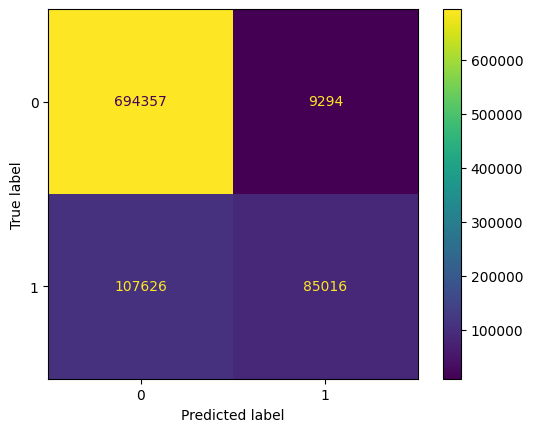

In [67]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [107]:
rfModel.featureImportances

SparseVector(111, {0: 0.0123, 1: 0.0, 3: 0.0082, 11: 0.0, 12: 0.0002, 13: 0.0055, 14: 0.0, 15: 0.0273, 17: 0.0, 18: 0.0, 19: 0.0, 20: 0.0053, 22: 0.0341, 23: 0.0719, 25: 0.0, 26: 0.0, 28: 0.019, 29: 0.0123, 30: 0.0001, 31: 0.0001, 32: 0.0003, 33: 0.0015, 41: 0.1247, 42: 0.0003, 43: 0.0005, 44: 0.0004, 48: 0.0112, 49: 0.0075, 51: 0.0145, 53: 0.028, 55: 0.0, 57: 0.0769, 58: 0.048, 60: 0.0002, 68: 0.003, 69: 0.0015, 70: 0.1076, 71: 0.2618, 73: 0.0, 75: 0.0, 76: 0.0014, 77: 0.061, 79: 0.0001, 80: 0.0013, 82: 0.0, 84: 0.0, 86: 0.0, 88: 0.0, 91: 0.0001, 92: 0.0, 93: 0.001, 94: 0.0011, 96: 0.0, 97: 0.0353, 98: 0.0, 99: 0.0, 101: 0.0, 102: 0.01, 104: 0.0, 106: 0.0042})

In [68]:
feat_imp = rfModel.featureImportances

In [69]:
feat_imp = [c for c in feat_imp]

In [70]:
feat_imp

[0.004221335908430208,
 1.92444780381726e-05,
 0.0,
 0.007154754029112155,
 0.0,
 0.0,
 0.0,
 0.0,
 0.006099127337668038,
 0.00470120560496752,
 1.519726546166712e-06,
 0.2614888539090518,
 1.0026498089081593e-06,
 3.151101642594829e-05,
 0.006775074408209293,
 0.0,
 0.0067658314595279295,
 6.9038312793140234e-06,
 0.0038798414787259163,
 0.0,
 0.032115402561955206,
 0.003154137085262064,
 0.0,
 1.3191620626118276e-05,
 2.3311904110134105e-06,
 0.0,
 0.002465865700251756,
 0.0012230863491762662,
 0.0,
 0.0,
 0.0,
 0.0030498446483451236,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.05323293163761855,
 0.0007398838366603348,
 0.0,
 0.0001248165915181304,
 0.0,
 0.0,
 1.6039998765502114e-06,
 0.0022073750388322804,
 0.004765964845868723,
 0.0,
 0.0003006824368837665,
 0.0,
 0.00045088222120598116,
 0.0,
 7.339967714393225e-05,
 0.0,
 0.014114329377707315,
 0.006286237584914213,
 0.0,
 0.003210704709898041,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.00010103130584529527,
 0.0004524379148

In [71]:
features_imp_pd = (
     pd.DataFrame(
       rfModel.featureImportances.toArray(),
       index=features_list,
       columns=['importance'])
)

In [72]:
features_imp_pd.sort_values(by=['importance'],ascending=False)


,importance
DiffPmt1,0.261489
LatePmt1_0,0.227436
LatePmt1_1,0.151956
PastTaxSaleStatus_Y,0.083217
PastTaxSaleStatus_N,0.063831
...,...
CondemnationStatus_0,0.000000
CondemnationStatus_1,0.000000
DisabledPersonVetExemptionAmount,0.000000
DisabledVetExemptionAmount,0.000000


# 3 year window model

In [79]:
train3y = train3year.persist()
train3y.count()

2537769

In [80]:
rf3 = RandomForestClassifier(featuresCol = 'features', labelCol = 'LatePmt2')
rfModel3 = rf3.fit(train3y)
predictions3 = rfModel3.transform(test2020)

In [81]:
actual3y = test2020.select(test2020.LatePmt2).toPandas()['LatePmt2']

In [82]:
element3y=f.udf(lambda v:float(v[1]),FloatType())
nums3y = [0.2, 0.25, 0.3, 0.35, 0.4,0.45, 0.5]
acc3y = []
f13y = []
rec3y = []
prec3y = []
for num3y in nums3y:
  print(num3y)
  predictions23y = predictions3.withColumn("prob_prediction", when(element3y("probability")>num3y, 1).otherwise(0))
  pred3y = predictions23y.select(predictions23y.prob_prediction).toPandas()["prob_prediction"]
  pred3y = pred3y.tolist()
  acc3y.append(accuracy_score(actual3y, pred3y))
  f13y.append(f1_score(actual3y, pred3y))
  rec3y.append(recall_score(actual3y, pred3y))
  prec3y.append(precision_score(actual3y, pred3y))

0.2
0.25
0.3
0.35
0.4
0.45
0.5


In [83]:
res_df3y = pd.DataFrame(nums3y, columns=["Threshold"])
res_df3y["Acc"] = acc3y
res_df3y["F1"] = f13y
res_df3y["Rec"] = rec3y
res_df3y["Prec"] = prec3y
res_df3y

,Threshold,Acc,F1,Rec,Prec
0,0.20,0.736428,0.495531,0.748927,0.370256
1,0.25,0.765419,0.513782,0.717041,0.400308
2,0.30,0.771132,0.514847,0.702568,0.406289
3,0.35,0.858693,0.564749,0.530375,0.603887
4,0.40,0.867261,0.550571,0.470384,0.663715
5,0.45,0.879518,0.515084,0.370201,0.846292
6,0.50,0.864748,0.366077,0.225935,0.964061


In [84]:
cm3y = confusion_matrix(actual3y, pred3y)
tn3y, fp3y, fn3y, tp3y = cm3y.ravel()

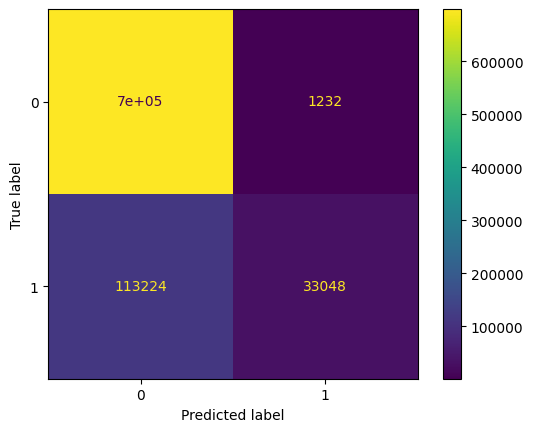

In [85]:
disp3y = ConfusionMatrixDisplay(confusion_matrix=cm3y)
disp3y.plot()
plt.show()

In [86]:
feat_imp3y = rfModel3.featureImportances

In [87]:
feat_imp3y = [c for c in feat_imp3y]

In [88]:
features_imp_pd3y = (
     pd.DataFrame(
       rfModel3.featureImportances.toArray(),
       index=features_list,
       columns=['importance'])
)

In [89]:
features_imp_pd3y.sort_values(by=['importance'],ascending=False)


,importance
LatePmt1_0,0.245087
DiffPmt1,0.223625
LatePmt1_1,0.116715
PastTaxSaleStatus_Y,0.098537
LastPaymentSource1_801,0.083308
...,...
LastPaymentSource1_472,0.000000
LastPaymentSource1_482,0.000000
LastPaymentSource1_471,0.000000
LastPaymentSource1_407,0.000000
